In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix 
from scipy import interp, stats
from imblearn.over_sampling import ADASYN 
import seaborn as sns

### TO LOAD DATA

In [2]:
# TO IMPORT CVS FILES (REGARDING FREQUENCY OF FEATURES)
all_features_list_df_cub=pd.read_csv("training_cubic_all_features_list_result.csv",index_col=False)
all_features_count_df_cub=all_features_list_df_cub.stack().value_counts() # it returns a df with the frequency for each features

In [3]:
# TO CREATE A PD DATAFRAME WITH ONLY THE FIRST n SELECTED FEATURES - TRAINING DATASET

first_n_features_to_select_cub = 7 # choose the value

# load the original dataset
training_dataframe_df_cub=pd.read_csv("training - cubic after WEKA CfsSubsetEval.csv",index_col='exam')
size_mapping={"codeletion":0,"noncodeletion":1} # MAPPING for outcome 
training_dataframe_df_cub["outcome"]=training_dataframe_df_cub["outcome"].map(size_mapping)

training_feature_names_cub = [x[2:-2] for x in [*all_features_count_df_cub.index]]
training_selected_features_cub = training_feature_names_cub[:first_n_features_to_select_cub]
training_New_dataframe_cub= training_dataframe_df_cub[training_selected_features_cub]
training_New_dataframe_cub["outcome"] = training_dataframe_df_cub["outcome"]
training_dataframe_with_selected_features_df_cub = training_New_dataframe_cub

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [4]:
print ("The chosen features are:", [x[1:-1] for x in [*training_selected_features_cub]])

The chosen features are: ['GLCM_average (T2)', 'Wavelet_LHL_Stats_median (T1)', 'Wavelet_LLH_Stats_median (T1)', 'GLCM_clusShade (T1)', 'Wavelet_LHH_Fractal_lacunarity (T2)', 'Wavelet_HLL_GLCM_correl1 (T2)', 'Wavelet_LLL_Stats_p10 (T2)']


## Training and testing the model on training dataset (CROSS VALIDATION)

In [5]:
model_cub = RandomForestClassifier(random_state=1, n_estimators=100) # Choose the model
CV = 10 # Choose the number of folds for cross validation
cv = StratifiedKFold(CV)

In [6]:
# To rename dataframe into X_np, Y_np (numpy arrays)
X_np_cub=training_dataframe_with_selected_features_df_cub.drop('outcome',axis=1).values
Y_np_cub=training_dataframe_with_selected_features_df_cub['outcome'].values

In [7]:
# Run classifier with cross-validation

Y_trues_cub = []
Y_predictions_cub = []
Y_probabilities_cub = []
all_accuracies_cub = []
aucs_cub = []
mean_fpr_cub = np.linspace(0, 1, 100)

for train_cub, test_cub in cv.split(X_np_cub, Y_np_cub):
    
    # StandardScaler
    ss = StandardScaler() 
    X_train_CV_SS_np_cub = ss.fit_transform(X_np_cub[train_cub]) 
    X_test_CV_SS_np_cub = ss.transform(X_np_cub[test_cub])
    
    # ADASYN
    sm = ADASYN(random_state=1)    
    X_train_CV_SS_BAL_np_cub, Y_train_CV_balanced_cub = sm.fit_sample(X_train_CV_SS_np_cub, Y_np_cub[train_cub])
    
    X_for_CV_model_training_cub = X_train_CV_SS_BAL_np_cub  
    Y_for_CV_model_training_cub = Y_train_CV_balanced_cub
    
    # fitting the model
    model_cub.fit (X_for_CV_model_training_cub, Y_for_CV_model_training_cub)
    
    # Compute prediction, probabilities and accuracy
    pred_cub_ = model_cub.predict(X_test_CV_SS_np_cub)
    probas_cub_ = model_cub.predict_proba(X_test_CV_SS_np_cub)
    accuracy_cub_ = accuracy_score(Y_np_cub[test_cub], pred_cub_)
    
    # Compute AUC
    fpr_cub, tpr_cub, thresholds_cub = roc_curve(Y_np_cub[test_cub], probas_cub_[:, 1])   
    roc_auc_cub = auc(fpr_cub, tpr_cub)    
    
    # Store data
    aucs_cub.append(roc_auc_cub)
    Y_trues_cub.extend(Y_np_cub[test_cub])
    Y_predictions_cub.extend(pred_cub_)
    Y_probabilities_cub.extend(probas_cub_)
    all_accuracies_cub.append(accuracy_cub_)

In [8]:
# Rename the values for bootstrap code and De-Long test
y_true_cub = np.array(Y_trues_cub)
y_pred_cub = np.array(Y_predictions_cub)
y_prob_cub = np.array(Y_probabilities_cub)[:,1]

In [9]:
# print Confusion Matrix
print ("Confusion matrix for cubic features (Cross Validation - training dataset): \n", confusion_matrix(y_true_cub, y_pred_cub))

Confusion matrix for cubic features (Cross Validation - training dataset): 
 [[87 15]
 [13 44]]


In [10]:
# Perform bootstrap with y_true, predictions, probabilities from CV model

n_bootstraps = 10000
rng_seed = 1  # control reproducibility

bootstrapped_acc_cub = []
bootstrapped_auc_cub = []
bootstrapped_sens_cub = []
bootstrapped_spec_cub = []

bootstrapped_tpr_cub = []
bootstrapped_fpr_cub = []
bootstrapped_thr_cub = []

bootstrapped_tprs_cub = []

mean_fpr = np.linspace(0, 1, 100)

rng = np.random.RandomState(rng_seed)

for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices_0=np.where(y_true_cub == 0)
    indices_1=np.where(y_true_cub == 1)
    
    # 'balanced bootstrapping'
    random_indices_0=rng.choice(indices_0[0],len(indices_0[0]))
    random_indices_1=rng.choice(indices_1[0],len(indices_0[0]))
    random_indices=np.concatenate((random_indices_0,random_indices_1), axis=None)
    
    acc_cub = accuracy_score(y_true_cub[random_indices], y_pred_cub[random_indices])
    auc_cub = roc_auc_score(y_true_cub[random_indices], y_prob_cub[random_indices])
    sens_cub = recall_score(y_true_cub[random_indices], y_pred_cub[random_indices], pos_label=1)
    spec_cub = recall_score(y_true_cub[random_indices], y_pred_cub[random_indices], pos_label=0)
    
    fpr_cub, tpr_cub, threshold_cub = roc_curve(y_true_cub[random_indices], y_prob_cub[random_indices])
    
    interp_tpr_cub = interp(mean_fpr, fpr_cub, tpr_cub)
    interp_tpr_cub[0] = 0.0
    bootstrapped_tprs_cub.append(interp_tpr_cub)
    
    bootstrapped_acc_cub.append(acc_cub)
    bootstrapped_auc_cub.append(auc_cub)
    bootstrapped_sens_cub.append(sens_cub)
    bootstrapped_spec_cub.append(spec_cub)

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.

metrics distributions for bootstrapping steps

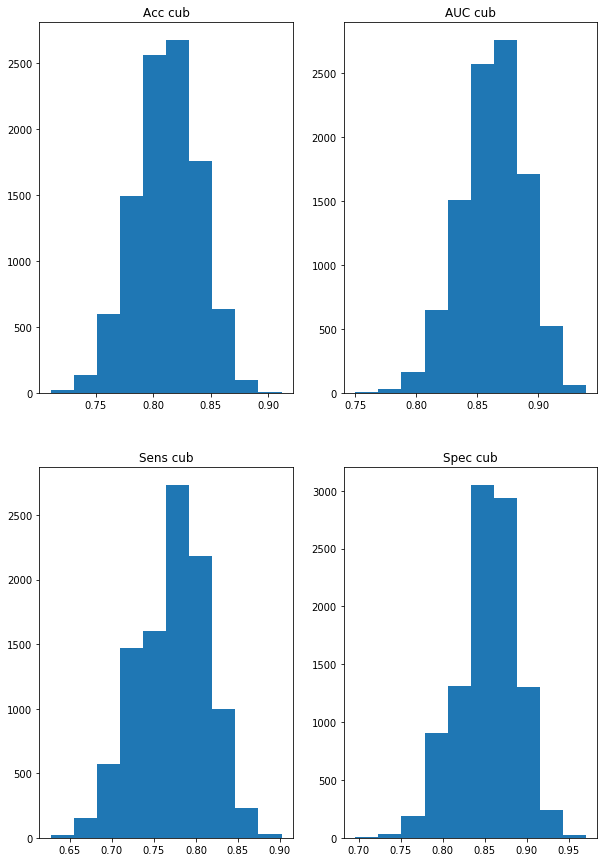

In [11]:
plt.figure(figsize=(10, 15))

plt.subplot(2,2,1)
plt.hist(bootstrapped_acc_cub)
plt.title('Acc cub')

plt.subplot(2,2,2)
plt.hist(bootstrapped_auc_cub)
plt.title('AUC cub')

plt.subplot(2,2,3)
plt.hist(bootstrapped_sens_cub)
plt.title('Sens cub')

plt.subplot(2,2,4)
plt.hist(bootstrapped_spec_cub)
plt.title('Spec cub')

plt.show()

distr normality test (Shapiro-Wilcoxon)

In [12]:
print ('Acc cub: ', stats.shapiro(bootstrapped_acc_cub))
print ('AUC cub: ', stats.shapiro(bootstrapped_auc_cub))
print ('Sens cub: ', stats.shapiro(bootstrapped_sens_cub))
print ('Spec cub: ', stats.shapiro(bootstrapped_spec_cub))

Acc cub:  (0.9961176514625549, 1.1081267239598206e-15)
AUC cub:  (0.9959251880645752, 3.873602634686695e-16)
Sens cub:  (0.9939232468605042, 3.488503370884549e-20)
Spec cub:  (0.9913932085037231, 4.1560146771132955e-24)


/Users/robertocasale/opt/anaconda3/envs/LGG/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-values are small -> distr is not normal -> estimation should be represented as median (low_percentile, up_percentile)

In [13]:
print ('Acc cub: {} ({}, {})'.format(np.median(bootstrapped_acc_cub), np.percentile(bootstrapped_acc_cub, 2.5), np.percentile(bootstrapped_acc_cub, 97.5)))
print ('AUC cub: {} ({}, {})'.format(np.median(bootstrapped_auc_cub), np.percentile(bootstrapped_auc_cub, 2.5), np.percentile(bootstrapped_auc_cub, 97.5)))
print ('Sens cub: {} ({}, {})'.format(np.median(bootstrapped_sens_cub), np.percentile(bootstrapped_sens_cub, 2.5), np.percentile(bootstrapped_sens_cub, 97.5)))
print ('Spec cub: {} ({}, {})'.format(np.median(bootstrapped_spec_cub), np.percentile(bootstrapped_spec_cub, 2.5), np.percentile(bootstrapped_spec_cub, 97.5)))

Acc cub: 0.8137254901960784 (0.7549019607843137, 0.8627450980392157)
AUC cub: 0.8638023836985774 (0.8100718473663976, 0.9096032775855439)
Sens cub: 0.7745098039215687 (0.6862745098039216, 0.8529411764705882)
Spec cub: 0.8529411764705882 (0.7843137254901961, 0.9215686274509803)


## ROC CURVE AND AUC

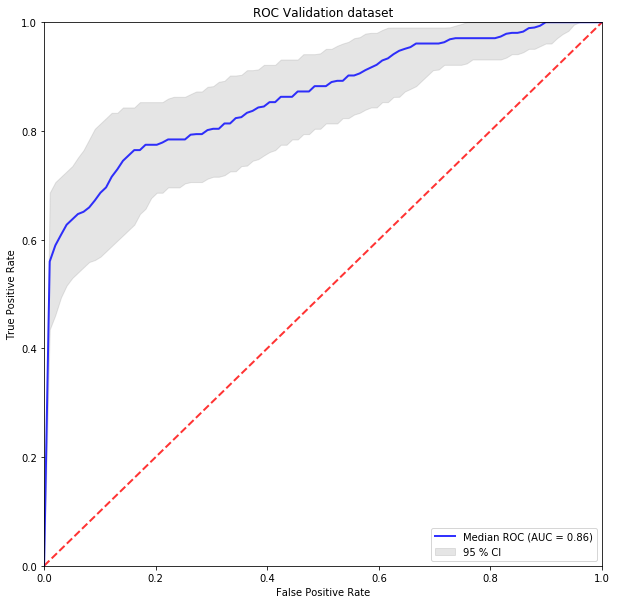

In [14]:
# ROC CURVE

fig, ax = plt.subplots(figsize=(10,10))  

plt.title('ROC Validation dataset')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)

mean_tpr_cub = np.median(bootstrapped_tprs_cub, axis=0)  
mean_tpr_cub[-1] = 1.0                
plt.plot(mean_fpr, mean_tpr_cub, color='b', 
        label=r'Median ROC (AUC = %0.2f)' % (np.median(bootstrapped_auc_cub)), 
        lw=2, alpha=.8)

tprs_upper = np.percentile(bootstrapped_tprs_cub, 2.5,  axis = 0)
tprs_lower = np.percentile(bootstrapped_tprs_cub, 97.5, axis = 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='95 % CI')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend(loc="lower right")
plt.show()